# 1. Regularized Linear Regression
## 1.1 Visualizing the dataset

We want to load the data, and visualize the training examples.

In [3]:
using Gadfly
using Optim
using MAT

Load the matlab data.

In [4]:
mat_data = matread("./data/ex5data1.mat")

Dict{String,Any} with 6 entries:
  "X"     => [-15.9368; -29.153; … ; 7.0135; 22.7627]
  "Xval"  => [-16.7465; -14.5775; … ; 46.2824; 14.6123]
  "yval"  => [4.1702; 4.06726; … ; 52.7819; 13.3573]
  "Xtest" => [-33.318; -37.9122; … ; -35.7086; 9.51021]
  "ytest" => [3.31689; 5.39769; … ; 4.69274; 10.83]
  "y"     => [2.13431; 1.17326; … ; 7.62766; 22.7524]

In [5]:
X, Xval, yval, Xtest, ytest, y = mat_data["X"], mat_data["Xval"],
                                 mat_data["yval"], mat_data["Xtest"],
                                 mat_data["ytest"], mat_data["y"]

(
[-15.9368; -29.153; … ; 7.0135; 22.7627],

[-16.7465; -14.5775; … ; 46.2824; 14.6123],

[4.1702; 4.06726; … ; 52.7819; 13.3573],

[-33.318; -37.9122; … ; -35.7086; 9.51021],

[3.31689; 5.39769; … ; 4.69274; 10.83],

[2.13431; 1.17326; … ; 7.62766; 22.7524])

Make plot for the training examples.

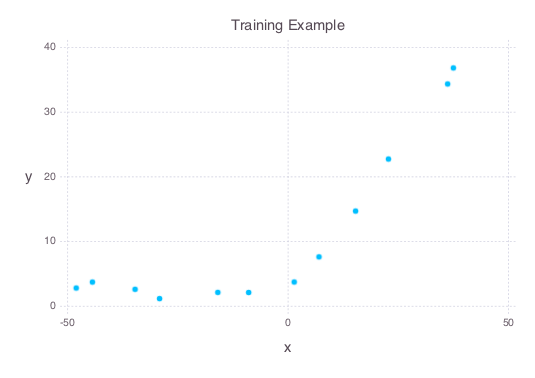

In [6]:
plot(x=X, y=y, Geom.point, Guide.title("Training Example"))

Based on the plot, assuming a linear relationship between y and all range of x is not that appropriate.

## 1.2 Regularized linear regression cost function
Then we can implement the mean squared error cost function for linear regression with Lasso penalty.

$$J(\theta) = \frac{1}{2m}\sum_{i=1}^{m}(h_{\theta}(x^{(i)}) - y^{(i)})^2 + \frac{\lambda}{2m}(\sum_{j=1}^n\theta_j^2)$$

Since there is only one feature, so the formula should be

$$J(\theta) = \frac{1}{2m}\sum_{i=1}^{m}(h_{\theta}(x^{(i)}) - y^{(i)})^2 + \frac{\lambda}{2m}\theta_1^2$$

We don't regulate $\theta_0$.

In [54]:
function cost{T1, T2, T3<:Real}(x::Array{T1}, y::Array{T2}, theta::Array{T3}, lambda=1)
    @assert size(x, 2) + 1 == size(theta, 1)
    
    m = size(x, 1)
    
    # Add the interception term to eamples
    x_full = hcat(ones(m), x)
    
    # Compute MSE
    y_hat = x_full * theta
    mse = sum((y_hat - y) .^ 2) / (2 * m)
    
    # Lasso Penalty
    penalty = (lambda / (2 * m)) * sum((theta .^ 2)[2:end])
    
    return mse + penalty
end

cost (generic function with 2 methods)

Test the `cost` function.

In [8]:
test_theta = [1; 1]
cost(X, y, test_theta)

303.9931922202643

## 1.3. Regularized linear regression gradient

Then we can implement the gradient for cost function with penalty.

$$\frac{\partial J(\theta)}{\partial \theta_0} = \frac{1}{m}\sum_{i=1}^{m}(h_{\theta}(x^{(i)}) - y^{(i)})x^{(i)}_0$$

$$\frac{\partial J(\theta)}{\partial \theta_j} = \frac{1}{m}\sum_{i=1}^{m}(h_{\theta}(x^{(i)}) - y^{(i)})x^{(i)}_j + \frac{\lambda}{m}\theta_j$$

In [61]:
function gradient{T1, T2, T3<:Real}(x::Array{T1}, y::Array{T2}, theta::Array{T3}, lambda=1)
    @assert size(x, 2) + 1 == size(theta, 1)
    
    m = size(x, 1)
    
    # Add the interception term to eamples
    x_full = hcat(ones(m), x)
    
    y_hat = x_full * theta
    
    # First column of full x are ones
    grad_0 = sum(y_hat - y) / m
    
    grad_other = []
    for c in 1:size(x,2)
        append!(grad_other, sum((y_hat - y) .* x[:,c]) / m + (lambda / m) * theta[c + 1])
    end
    
    return vcat(grad_0, grad_other)
end

gradient (generic function with 2 methods)

Test the gradient function.

In [10]:
gradient(X, y, test_theta)

2-element Array{Float64,1}:
 -15.303
 598.251

## 1.4. Fitting linear regression
Set $\lambda$ to 0, then fit the line.

In [11]:
function grad!(theta, store; feature=X, y=y, lambda=1)
    store[:] = gradient(feature, y, theta, lambda)
end
res = optimize(t -> cost(X, y, t, 0), (t, s) -> grad!(t, s, feature=X, y=y, lambda=0), [0.0, 0.0])

Results of Optimization Algorithm
 * Algorithm: BFGS
 * Starting Point: [0.0,0.0]
 * Minimizer: [13.087903510869076,0.36777922974565114]
 * Minimum: 2.237391e+01
 * Iterations: 2
 * Convergence: true
   * |x - x'| < 1.0e-32: false
   * |f(x) - f(x')| / |f(x)| < 1.0e-32: false
   * |g(x)| < 1.0e-08: true
   * f(x) > f(x'): false
   * Reached Maximum Number of Iterations: false
 * Objective Function Calls: 8
 * Gradient Calls: 8

Plot the linear model along with training examples.

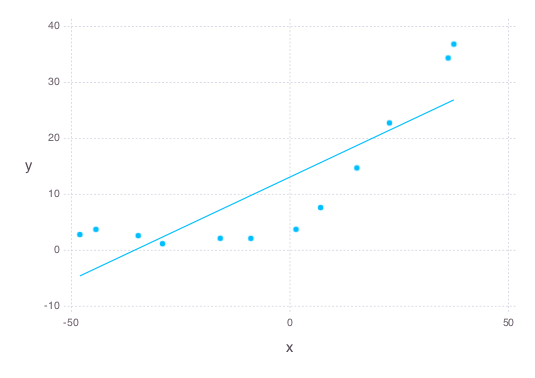

In [12]:
theta_1 = Optim.minimizer(res)
linear_model(x) =  theta_1[1] + x * theta_1[2]
plot(layer(linear_model, minimum(X), maximum(X)),
     layer(x=X, y=y, Geom.point))

# 2. Bias-variance
## 2.1. Learning curves

In this section, we will implement a function to compute the training set error as well as the validation set error. Then plot a learning curve.

In [178]:
"""
Train a slr model using given x and y, return training and validation MSE
"""
function get_cv_errors(x, y; lambda=1, normal=false)
    nx = normal ? normalize(x) : x

    # Train the model
    res = optimize(t -> cost(nx, y, t, 0), (t, s) -> grad!(t, s, feature=nx, y=y, lambda=0), 
                   zeros(size(nx, 2) + 1))
    best_theta = Optim.minimizer(res)
    
    # Compute the error
    train_error = cost(nx, y, best_theta, 0)
    
    # Ensure val matrix 
    val_poly = get_poly(Xval, size(x, 2))
    val_error = cost(normal ? normalize(val_poly) : val_poly, yval, best_theta, 0)
    
    return (train_error, val_error)
end

get_cv_errors

In [172]:
# Shuffle training set
indices = rand(1:size(X, 1), size(X, 1))
X_shuffled, y_shuffled = X[indices], y[indices]

# Collect errors
train_errors, val_errors = [], []

for i in 1:size(X, 1)
    errors = get_cv_errors(X_shuffled[1:i,], y[1:i,]; lambda=0, normal=false)
    append!(train_errors, errors[1])
    append!(val_errors, errors[2])
end

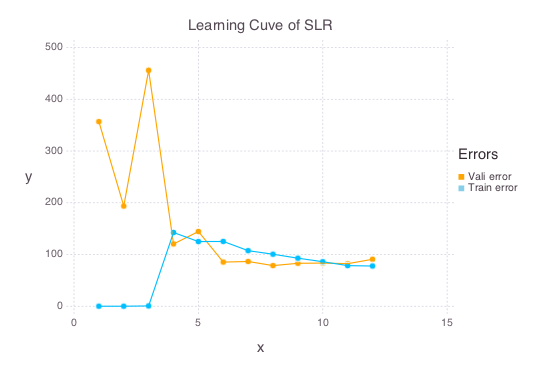

In [173]:
plot(layer(x=1:size(X, 1), y=train_errors, Geom.line, Geom.point),
     layer(x=1:size(X, 1), y=val_errors, Geom.line, Geom.point, Theme(default_color=colorant"orange")),
     Guide.title("Learning Cuve of SLR"),
     Guide.manual_color_key("Errors", ["Vali error", "Train error"], [colorant"orange", colorant"skyblue"]))

This plot is slightly different form the graphs given on the instruction, since we are using random sampling. However, we still can see that the model has high variance when given a small number of training examples. While increasing the size of training examples, the variance decreases but the bias is still high.

# 3. Polynomial regression
## 3.1 Learning Polynomial Regression
SLR model is too simple, we want to try add more features into our model. The most direct way is to introduce the power of existing features.

We first implement a function to map original X into a polynomial.

In [41]:
"""
Map a m*1 training matrix into m*p matrix, where each row is the polynomial term
of coresponding row.

For example, [3; 4] would be mapped to [3, 9, 27; 4, 16, 64] when p = 3.
"""
function get_poly{T<:Real}(x::Array{T}, p::Int64)
    result = x[:]
    for i in 2:p
        result = hcat(result, result[:,1] .^ i)
    end
    return result
end     

get_poly

In [63]:
a = [1,2,3]
get_poly(a, 4)

3×4 Array{Int64,2}:
 1  1   1   1
 2  4   8  16
 3  9  27  81

Then we need a normalization function to normalize the features.

In [72]:
"""
Use mean, sd to normalize the feature matrix.
"""
normalize{T<:Real}(x::Array{T}) = (x .- mean(x)) ./ std(x)

normalize

Next we fit the new model using training examples (using $\lambda = 0, p = 8$).

In [219]:
x_p8 = get_poly(X, 8)
res = optimize(t -> cost(x_p8, y, t, 0), 
               (t, s) -> grad!(t, s, feature=x_p8, y=y, lambda=0),
               zeros(9))

Results of Optimization Algorithm
 * Algorithm: BFGS
 * Starting Point: [0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]
 * Minimizer: [3.612731209690701,0.3182869351490222, ...]
 * Minimum: 2.889024e-02
 * Iterations: 12
 * Convergence: false
   * |x - x'| < 1.0e-32: false
   * |f(x) - f(x')| / |f(x)| < 1.0e-32: false
   * |g(x)| < 1.0e-08: false
   * f(x) > f(x'): true
   * Reached Maximum Number of Iterations: false
 * Objective Function Calls: 37
 * Gradient Calls: 37

Then we can plot the new model along with training examples.

In [220]:
mini_theta = Optim.minimizer(res)
# Function for plotting
poly_model{T<:Real}(x::Real, theta::Array{T}) = (hcat([1], get_poly([x], size(theta, 1) - 1)) * theta)[1]

poly_model (generic function with 1 method)

In [216]:
get_poly([2],8)

1×8 Array{Int64,2}:
 2  4  8  16  32  64  128  256

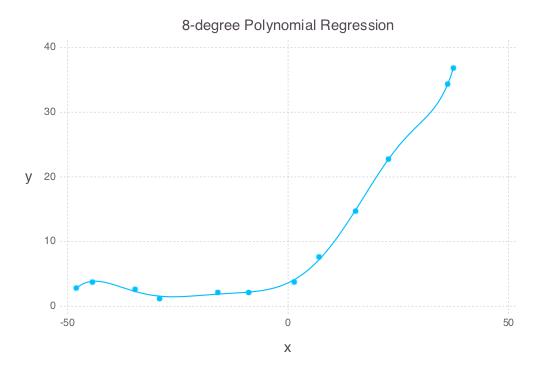

In [221]:
plot(layer(x -> poly_model(x, mini_theta), minimum(X), maximum(X)),
     layer(x=X, y=y, Geom.point),
     Guide.title("8-degree Polynomial Regression"))

We can see the model fits the dots almost perfectly, it might lead to overfitting problem. We can plot the learning curve to check the variance and bias.

In [207]:
# Shuffle training set
indices = rand(1:size(X, 1), size(X, 1))
X_shuffled, y_shuffled = X[indices], y[indices]

# Collect errors
train_errors, val_errors = [], []

for i in 1:size(X, 1)
    errors = get_cv_errors(get_poly(X_shuffled[1:i,], 8), y[1:i,]; lambda=0, normal=true)
    append!(train_errors, errors[1])
    append!(val_errors, errors[2])
end

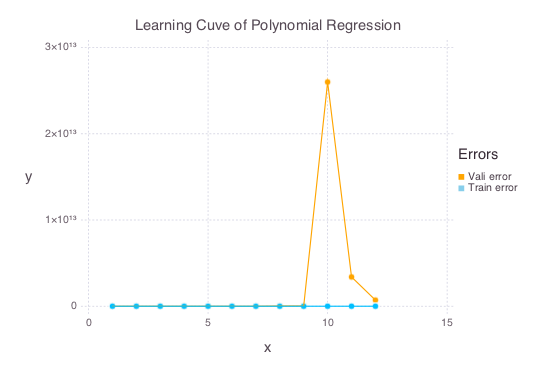

In [208]:
plot(layer(x=1:size(X, 1), y=train_errors, Geom.line, Geom.point),
     layer(x=1:size(X, 1), y=val_errors, Geom.line, Geom.point, Theme(default_color=colorant"orange")),
     Guide.title("Learning Cuve of Polynomial Regression"),
     Guide.manual_color_key("Errors", ["Vali error", "Train error"], [colorant"orange", colorant"skyblue"]))

The plot looks different from the plot on the instruction, because ours is not scaled. We can plot another graph starting from training size = 8.

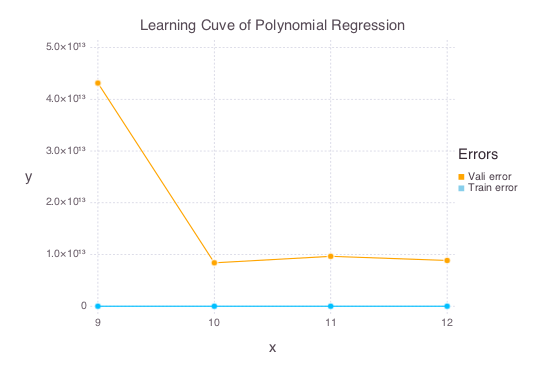

In [171]:
plot(layer(x=9:size(X, 1), y=train_errors[9:end], Geom.line, Geom.point),
     layer(x=9:size(X, 1), y=val_errors[9:end], Geom.line, Geom.point, Theme(default_color=colorant"orange")),
     Guide.title("Learning Cuve of Polynomial Regression"),
     Guide.manual_color_key("Errors", ["Vali error", "Train error"], [colorant"orange", colorant"skyblue"]))

The error is still very large, since we are using 8-degree polynomial. Also from the plot we know there is overfiting problem in this model. 